In [1]:
# !pip install build-essential
# !pip install pydot
# !pip install graphviz

In [2]:
import numpy as np
import re

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,SpatialDropout1D,LSTM
from keras.callbacks import EarlyStopping

import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import pandas as pd
pd.set_option('max_columns', None)

from data_frame import eda_nltk, remove_tags

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes = True)


import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peeti_mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataframe = input(': ') #reviews_Automotive_5.json.gz
df = eda_nltk(dataframe)
df.head()

: reviews_Automotive_5.json.gz


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


In [4]:
df['positive'] = df.overall.apply(lambda x: 1 if x >= 4 else 0)
print(df.shape)


(20473, 10)


# Data Preprocessing

In [5]:
review_df = df[['reviewText','positive']]
review_df['reviewText']=review_df['reviewText'].apply(lambda cw : remove_tags(cw))



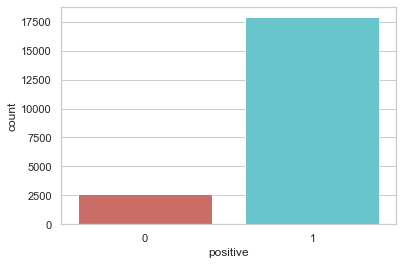

In [6]:
sns.countplot(x='positive',data = review_df, palette = 'hls')
plt.show()

# imbalanced data

## start random select

In [7]:
max_cnt = review_df.query('positive == 0').shape[0]
print(f'We should select only {max_cnt} count for both positive/ negative review')
sample_df = review_df.groupby(['positive']).apply(lambda x: x.sample(max_cnt))
sample_df.shape[0]

We should select only 2578 count for both positive/ negative review


5156

### remove stopwords from the review. Stopwords are commonly used words like ‘and’, ‘the’, ‘at’ that do not add any special meaning or significance to a sentence

In [8]:
sample_df['reviewText'] = sample_df['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
sample_df['reviewText']

positive       
0         11490    product best car mean alex customer service pe...
          13616    wheel cleaner better stuff sold autozone types...
          12794    one bottom step getting going buy another one ...
          6474     kit work way thought would hard time keeping s...
          9011     pin 10mm wide disc brake holes disk wide lock ...
                                         ...                        
1         5871     pt cruiser already replaced nozzles steep deal...
          1893     bought 2003 bmw r 1150r even female understand...
          15748    inexpensive goggle gets job done seem fog quic...
          6036     using years never replace water pump thermosta...
          92       rain x 800002243 glass treatment 7 oz simple s...
Name: reviewText, Length: 5156, dtype: object

In [9]:

review_list = [i for i in sample_df['reviewText']]
review_list[:2]

['product best car mean alex customer service person helpful help returning package even broke bulb said prob deduct bulb cost u still return',
 'wheel cleaner better stuff sold autozone types stores quite good enough bmw wheels notorious brake dust use little brush get stubborn grime']

In [10]:
sample_df['reviewText'].values

array(['product best car mean alex customer service person helpful help returning package even broke bulb said prob deduct bulb cost u still return',
       'wheel cleaner better stuff sold autozone types stores quite good enough bmw wheels notorious brake dust use little brush get stubborn grime',
       'one bottom step getting going buy another one put end one keeps moving around well made good quality unit',
       ...,
       'inexpensive goggle gets job done seem fog quickly first put riding wind clears fog',
       'using years never replace water pump thermostat radiator worth money',
       'rain x 800002243 glass treatment 7 oz simple stuff works great applied correctly rain slide right'],
      dtype=object)

In [11]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(sample_df['reviewText'].values)
X = tokenizer.texts_to_sequences(sample_df['reviewText'].values)
X = pad_sequences(X)
X

array([[   0,    0,    0, ..., 1235,   48,  508],
       [   0,    0,    0, ...,  241,    9, 1106],
       [   0,    0,    0, ...,    6,   42,   85],
       ...,
       [   0,    0,    0, ..., 1099, 1130, 1162],
       [   0,    0,    0, ..., 1971,  141,  143],
       [   0,    0,    0, ...,  267,  798,   73]], dtype=int32)

In [12]:
# t=Tokenizer()
# t.fit_on_texts(review_list)
# sequences =t.texts_to_sequences(review_list)
# X = pad_sequences(sequences)
# print(X)

In [13]:
# print('sequences : ',sequences[:2],'\n')


# N = len([item for sublist in sequences[:2] for item in sublist])

# print('word_index : ',{k: t.word_index[k] for k in list(t.word_index)[:N]})


In [14]:
# len_mat=[]
# for i in range(len(sequences)):
#     len_mat.append(len(sequences[i]))

In [15]:
# len(len_mat)

In [16]:
s = 0.0
for i in sample_df['reviewText']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/sample_df.shape[0])
pos = 0
for i in range(sample_df.shape[0]):
    if sample_df.iloc[i]['positive'] == 1:
        pos = pos + 1
neg = sample_df.shape[0]-pos
print("Percentage of reviews with positive sentiment is "+str(pos/sample_df.shape[0]*100)+"%")
print("Percentage of reviews with negative sentiment is "+str(neg/sample_df.shape[0]*100)+"%")


Average length of each review :  48.846392552366176
Percentage of reviews with positive sentiment is 50.0%
Percentage of reviews with negative sentiment is 50.0%


# Build LSTM Model

#### For the models we will use, we need to define a maximum sequence length (max number of tokens per review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter reviews with zeros at the end.

In [17]:
max_features = 2000
embed_dim = 64
lstm_out = 16

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid',trainable=True))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 896, 64)           128000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 896, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 133,201
Trainable params: 133,201
Non-trainable params: 0
_________________________________________________________________
None


2023-09-13 21:56:39.693060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


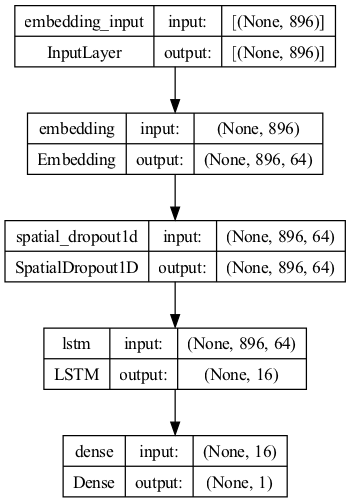

In [18]:
plot_model(model, show_shapes=True, dpi=90)

In [19]:
y = sample_df['positive']
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)



(4124, 896) (4124,)
(1032, 896) (1032,)


In [20]:
batch_size = 32
model.fit(X_train, Y_train, 
          epochs = 6,
          batch_size = batch_size,
          validation_data = (X_test, Y_test),
          callbacks = [EarlyStopping(monitor='val_accuracy', min_delta = 0.001, patience=2,verbose=2)])

Epoch 1/6
129/129 [==============================] - 80s 603ms/step - loss: 0.6558 - accuracy: 0.6091 - val_loss: 0.5698 - val_accuracy: 0.7326
Epoch 2/6
129/129 [==============================] - 77s 598ms/step - loss: 0.4764 - accuracy: 0.7859 - val_loss: 0.5393 - val_accuracy: 0.7287
Epoch 3/6
129/129 [==============================] - 66s 511ms/step - loss: 0.3778 - accuracy: 0.8421 - val_loss: 0.5662 - val_accuracy: 0.7364
Epoch 4/6
129/129 [==============================] - 63s 485ms/step - loss: 0.3176 - accuracy: 0.8792 - val_loss: 0.6319 - val_accuracy: 0.7180
Epoch 5/6
129/129 [==============================] - 71s 552ms/step - loss: 0.2741 - accuracy: 0.8972 - val_loss: 0.6837 - val_accuracy: 0.7190
Epoch 5: early stopping
